Make historical HDD mean (base) 

In [ ]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt

import math

import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../")))  # set vscode notebook path for module imports
from utils.tools import regions_from_xarray

In [ ]:
#Read Zarr dataset from earthdatahub destine EU
ds = xr.open_dataset(
    "https://data.earthdatahub.destine.eu/era5/era5-land-daily-utc-v1.zarr",
    storage_options={"client_kwargs":{"trust_env":True}},
    chunks={},
    engine="zarr",
)

#Reassign longitude to be -180, 180
if ds.longitude.max() > 180:
    ds = ds.assign_coords(longitude=((ds.longitude + 180) % 360) - 180)
    ds = ds.sortby("longitude")
ds_us = ds.sel(**{"latitude": slice(50, 24), "longitude": slice(-125, -67)}) #Slice to get only US 

#Format dataset for HDD
t2m_us = ds_us.t2m #Keep only 2m temperature
t2m_us = (t2m_us - 273.15) * 1.8 + 32 #Convert kelvin to °F
t2m_us.attrs['units'] = '°F'
t2m_30years_us = t2m_us.sel(valid_time=slice('1995', '2025')) #Select last 30 years

hdd = (65 - t2m_30years_us).clip(min=0) #make max(0, 65 - t2m)

#Population reggrided to ERA5-Land dataset
pop = xr.open_dataarray('../utils/files/population_regridded_01deg.nc') #from reproject_and_align_pop function in tools

hdd_weighted = hdd * pop #Weight the hdd by population for each point in the grid and each valid_time

hdd_weighted_yearly_mean = hdd_weighted.groupby(hdd_weighted.valid_time.dt.dayofyear).mean() #Make the mean of each grid point for each day of year (1-365)
hdd_weighted_yearly_mean_computed = hdd_weighted_yearly_mean.compute() #here we finally compute the xarray because that's the one we will then manipulate for US and subregion mean

In [ ]:
#Make US sum
us_yearly_sum = hdd_weighted_yearly_mean_computed.sum(dim=['latitude', 'longitude']) #Mean every point in the US to have one mean weighted HDD for each day of year
us_pop_sum = pop.sum(dim=['latitude', 'longitude'])
base_us_weighted_hdd = us_yearly_sum / us_pop_sum
base_us_weighted_hdd_df = base_us_weighted_hdd.to_dataframe(name='US Mean')
base_us_weighted_hdd_df = base_us_weighted_hdd_df[['US Mean']]

#Make subregion sum
zone_means = regions_from_xarray(hdd_weighted_yearly_mean_computed, pop)

#Make a dataframe from mean dict with day of year as index and regions as columns
subregion_yearly_mean_df = pd.DataFrame({zone: data.values for zone, data in zone_means.items()}, index=hdd_weighted_yearly_mean_computed.dayofyear.values)

us_base_hdd = pd.concat([base_us_weighted_hdd_df, subregion_yearly_mean_df], axis=1) #add US Mean to a new column

if 366 in us_base_hdd.index: #if 366 days in a year, we remove the last one (366th)
    us_base_hdd = us_base_hdd.drop(index=366)

Let's plot the historical (30 years) average HDD

In [35]:
us_base_hdd = pd.read_csv('../utils/files/base_revised.csv')
us_base_hdd = us_base_hdd.rename(columns={'Unnamed: 0': 'Day of year'})
us_base_hdd = us_base_hdd.set_index('Day of year')

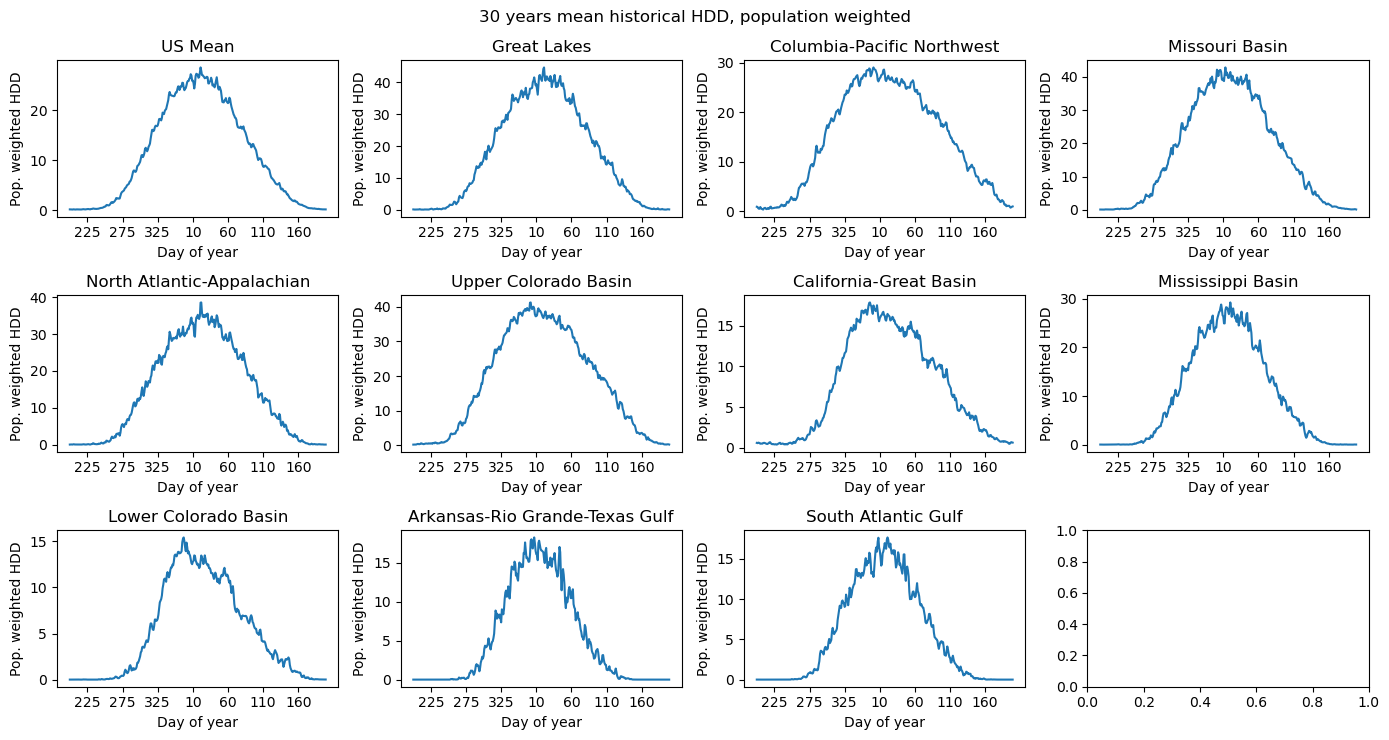

In [36]:
us_base_hdd_rearranged = pd.concat([us_base_hdd.loc[200:365], us_base_hdd.loc[0:199]]) #rearrange the index for a better plot

cols = 4
rows = math.ceil(len(us_base_hdd_rearranged.columns) / cols)

fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(14, 2.5 * rows))
ax = ax.flatten()

tick_positions = range(25, len(us_base_hdd_rearranged), 50)  #Every 50 days
tick_labels = [us_base_hdd_rearranged.index[pos] for pos in tick_positions]

for i, col in enumerate(us_base_hdd_rearranged.columns):
    ax[i].plot(us_base_hdd_rearranged[col].values)
    ax[i].set_title(f'{col}')
    ax[i].set_xticks(tick_positions)
    ax[i].set_xticklabels(tick_labels)
    ax[i].set_xlabel('Day of year')
    ax[i].set_ylabel('Pop. weighted HDD')
plt.suptitle('30 years mean historical HDD, population weighted')
plt.tight_layout()
plt.show()